In [7]:
# Environment
# Python: 3.9.16
# Important Package: Tensorflow: 2.8.0, Keras: 2.8.0, Livelossplot: 0.5.5

# Import Module
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
# Preprocessing The Image Data

# Gaussian Blur
def USM_Sharpen(image, sigma):
    blur_image = cv2.GaussianBlur(image, (0, 0), sigma)
    usm = cv2.addWeighted(image, 1.5, blur_image, -0.5, 0)
    return usm

# Laplacian Sharpening
def Laplace_Sharpen(image):
    blur_image = cv2.Laplacian(image, -1)
    laplace = cv2.addWeighted(image, 1, blur_image, -0.5, 0)
    return laplace

def Preprocessing(data_dir, save_dir, dim, format):
    image_Filename_List = os.listdir("./" + data_dir + "/")
    savePath = os.path.abspath(os.getcwd()) + '/' + save_dir
    # Check if Dir Doesn't Exist
    if not os.path.isdir(savePath):
        os.mkdir(savePath)
    
    for image in image_Filename_List:
        filename = image.split('.')[0]
        per_image = cv2.imread(os.getcwd() + '\\' + data_dir + '\\' + image)
        # Convert to GrayScale
        gray_image = cv2.cvtColor(per_image, cv2.COLOR_BGR2GRAY)
        # Set the Resize Width and Height
        resize_image = cv2.resize(gray_image, dim, interpolation = cv2.INTER_AREA) # Interpolation Method
        # Sharpen
        sharpen_image = USM_Sharpen(resize_image, 10)
        # Save Images
        cv2.imwrite(os.getcwd() + '\\' + save_dir + '\\' + filename + format, sharpen_image)

Preprocessing("New", "NewTest", (116 * 2, 164 * 2), ".jpg")

In [3]:
# Read Data and Generate X_Train, Y_Train

def ReadData(image_dir, excel_name, dim):
    # Read Excel and Assign to DataFrame
    df = pd.read_excel(os.getcwd() + '\\' + excel_name)
    # Find NaN Cells and Drop it
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    # If Want to Print Nan Cells
    '''
    df_checkNaN = df.isna()
    print(df_checkNaN.values.sum())
    '''
    df.dropna(inplace = True)

    # Initialize Array (Global)
    global Total_Rows, X_Train, X_Name, Y_Train # Define Global Variables
    Total_Rows = df.shape[0]
    X_Train = np.zeros((Total_Rows, dim[0], dim[1], 1))
    X_Name = np.empty(Total_Rows, dtype = 'object')
    Y_Train = np.zeros((Total_Rows, 18), dtype = 'int64')

    # Initialize List
    Filename_List = df.檔案名稱.tolist()
    # Change to String List
    Filename_List = [str(elements) for elements in Filename_List]
    Image_List = os.listdir("./" + image_dir + "/")

    # Read Data
    i = 0
    for image in Image_List:
        # Cause Filename "Data (n)" Mismatch Excel Cell "Data(n)"
        filename = image.replace(' ', '').replace('.jpg', '')
        # Check Filename is in Excel
        if filename in Filename_List:
            # Generate Y_Train
            # Filename need to check
            index = df[df.檔案名稱 == int(filename)].index.tolist()
            per_Data = df.loc[index, ["基本圖形(大)", "基本圖形(中)", "基本圖形(內)", "大小(外)", "大小(中)", "大小(內)", "邊(外)", "邊(中)", "邊(內)", "方向(直)", "方向(橫)", "重疊(上)", "重疊(下)", "重疊(左)", "重疊(右)", "開合度(外)", "開合度(中)", "開合度(內)"]].astype(int).to_numpy()
            Y_Train[i] = per_Data
            # Generate X_Train
            per_image = cv2.imread(os.getcwd() + '\\' + image_dir + '\\' + image, cv2.IMREAD_GRAYSCALE)
            # Normalization
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler(feature_range=(0, 1))
            norm_per_image = scaler.fit_transform(per_image)
            X_Train[i] = norm_per_image.reshape(-1, dim[0], dim[1], 1)
            X_Name[i] = filename
            i = i + 1

ReadData("NewTest", "score2.xlsx", (164 * 2, 116 * 2))

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
import keras.metrics
import keras.optimizers

# Create CNN Model
def CreateModel(input_dim):
    # Define Global Model
    global Model
    Model = Sequential()
    # Input Layers
    Model.add(Conv2D(filters = 8, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_dim))
    # Convolutional Layers
    Model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
    Model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
    Model.add(MaxPooling2D(pool_size = (2, 2)))
    Model.add(Dropout(0.2))
    
    Model.add(Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
    Model.add(Conv2D(filters = 24, kernel_size = (3, 3), activation = 'relu'))
    Model.add(MaxPooling2D(pool_size = (2, 2)))
    Model.add(Dropout(0.2))

    Model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    Model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu'))
    Model.add(MaxPooling2D(pool_size = (4, 4)))
    Model.add(Dropout(0.2))
    
    # Fully-Connected Layer
    Model.add(Flatten())
    Model.add(Dense(1024, activation = 'relu', kernel_regularizer='l2'))
    Model.add(Dropout(0.2))
    Model.add(Dense(18, activation = 'sigmoid'))

    # Compile Model
    opt = keras.optimizers.Nadam(learning_rate = 0.002)
    Model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [keras.metrics.binary_accuracy])
    Model.summary()

# Display Model
def DisplayModel():
    plot_model(Model, show_shapes = True, show_layer_names = False)

CreateModel((164 * 2, 116 * 2, 1))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 328, 232, 8)       80        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 328, 232, 16)      1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 326, 230, 16)      2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 163, 115, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 163, 115, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 163, 115, 24)      3480      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 161, 113, 24)     

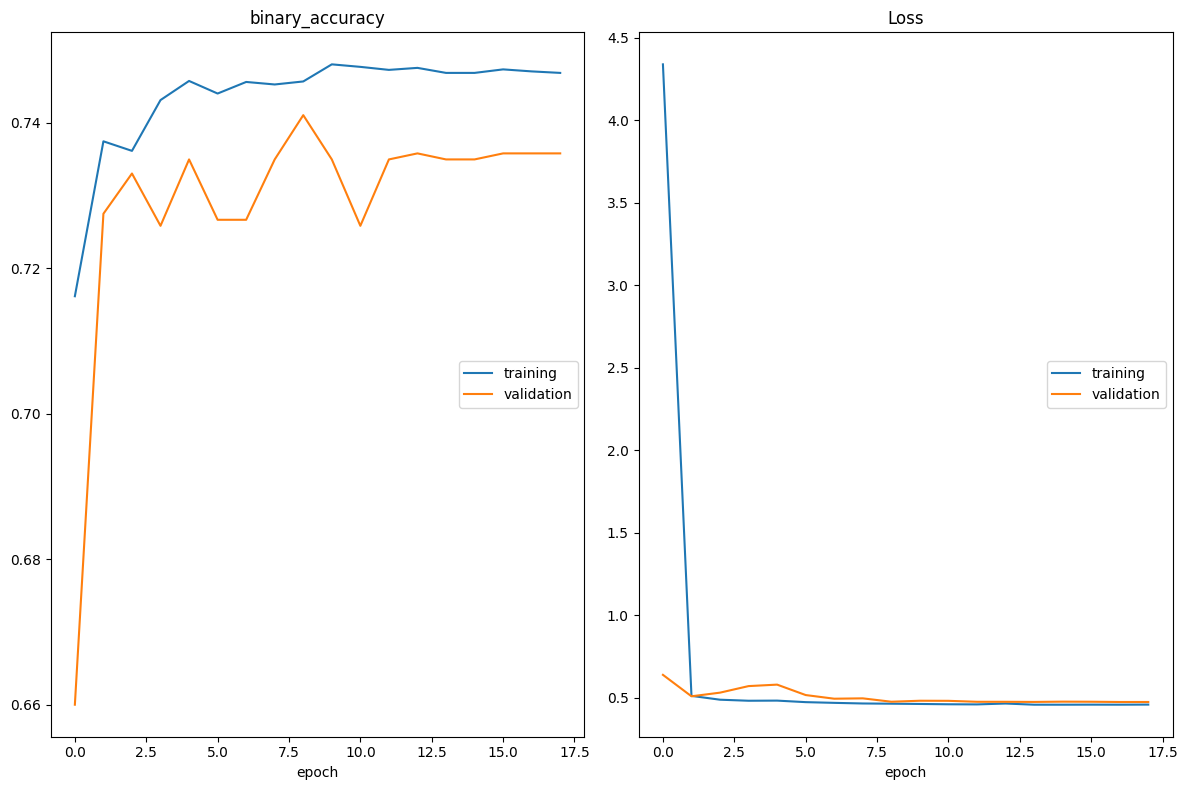

binary_accuracy
	training         	 (min:    0.716, max:    0.748, cur:    0.747)
	validation       	 (min:    0.660, max:    0.741, cur:    0.736)
Loss
	training         	 (min:    0.457, max:    4.339, cur:    0.458)
	validation       	 (min:    0.474, max:    0.638, cur:    0.474)
Epoch 19/64
 3/26 [==>...........................] - ETA: 1s - loss: 0.4648 - binary_accuracy: 0.7419

KeyboardInterrupt: 

In [6]:
from livelossplot import PlotLossesKeras

# Training Model
def Training(n_epochs, n_batchsize, split_percent):
    History = Model.fit(X_Train, Y_Train, 
                        epochs = n_epochs, 
                        batch_size = n_batchsize, 
                        callbacks = [PlotLossesKeras()], 
                        validation_split = split_percent, 
                        shuffle = True, 
                        verbose = 1)
Training(64, 32, 0.2)

In [64]:
# Evaluate Model Accuracy

def Evaluate_Accuracy():
    # Predict The Scores
    Pred = Model.predict(X_Train[0:Total_Rows])
    # Answer is Neither 0 nor 1, The Threshold = 0.5
    Ans = np.where(Pred > 0.5, 1, 0)

    All_Corrects_Num = 0
    Error_Score_Distribution = np.zeros((19), dtype = int)
    Each_Score_Accuracy = np.zeros((18), dtype = int)
    for i in range(0, Total_Rows):
        Error_Score_Distribution[abs(np.sum(Y_Train[i]) - np.sum(Ans[i]))] += 1
        if np.array_equiv(Ans[i], np.trunc(Y_Train[i])):
            All_Corrects_Num += 1
            for i in range(18):
                Each_Score_Accuracy[i] += 1
        else:
            for j in range(18):
                if not np.array_equiv(Ans[i][j], np.trunc(Y_Train[i][j])):
                    Each_Score_Accuracy[j] += 1
            if abs(np.sum(Y_Train[i]) - np.sum(Ans[i])) >= 12:
                print(X_Name[i])
                print(Y_Train[i])
                print(Ans[i])

    print("All Corrects Ratio = ", All_Corrects_Num / Total_Rows)
    print("Error Distribution = ", Error_Score_Distribution)
    print("Each Score Accuracy = ", Each_Score_Accuracy)

Evaluate_Accuracy()

All Corrects Ratio =  0.8009950248756219
Error Distribution =  [847  78  44  13  14   5   2   1   1   0   0   0   0   0   0   0   0   0
   0]
Each Score Accuracy =  [822 867 862 830 870 851 840 869 868 805 805 815 812 819 812 892 887 883]


In [6]:
# Load Model
def LoadModel(modelName):
    global Model
    Model = load_model(modelName)

# Save Model
def SaveModel(modelName):
    Model.save(modelName)

# LoadModel('l2_model_final_overfitting.h5')
SaveModel('local_1024eps.h5')